In [14]:
import matplotlib.pyplot as plt
import torch
from torch.nn import Conv2d, CrossEntropyLoss, Linear, MaxPool2d, Module
from torch.nn.functional import relu
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms.v2 import Compose, ToImageTensor, ConvertImageDtype

In [15]:
# Define the transformation to apply to the data
transform = Compose([ToImageTensor(), ConvertImageDtype(torch.float32)])

# Load the MNIST dataset
trainset = MNIST("mnist_data", download=True, train=True, transform=transform)
testset = MNIST("mnist_data", download=True, train=False, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Define the data loaders for the training, validation, and testing sets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

In [16]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

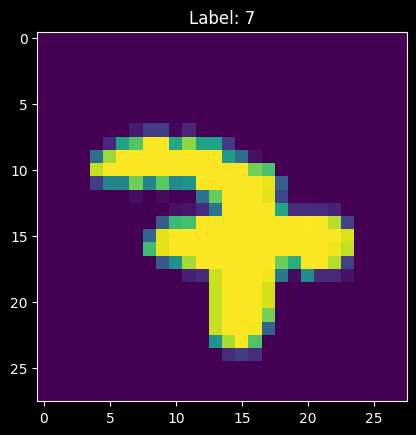

In [17]:
# Get a random image from the training set
image, label = trainset[0]

# Plot the image
plt.imshow(image.squeeze())
plt.title(f"Label: {label}")
plt.show()

In [18]:
device = torch.device("mps")

In [19]:
class ConvNet(Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding="same")
        self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding="same")
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = Linear(64 * 7 * 7, 128)
        self.fc2 = Linear(128, 10)

    def forward(self, x):
        x = relu(self.conv1(x))
        x = self.pool(x)
        x = relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
model = ConvNet().to(device)

In [21]:
# Define the loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 5

# Initialize lists to store training and validation statistics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs = inputs.to(
            device, dtype=torch.float32
        )  # convert input tensor to float32
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy and loss
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

        # Print statistics
        if i % 100 == 99:
            # Compute validation accuracy and loss
            correct_val = 0
            total_val = 0
            val_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    images = images.to(
                        device, dtype=torch.float32
                    )  # convert input tensor to float32
                    labels = labels.to(device)
                    images, labels = data
                    images = images.to(
                        device, dtype=torch.float32
                    )  # convert input tensor to float32
                    labels = labels.to(device)
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            # Print statistics
            train_losses.append(running_loss / 100)
            train_accs.append(100 * correct_train / total_train)
            val_losses.append(val_loss / len(valloader))
            val_accs.append(100 * correct_val / total_val)
            print(
                f"[Epoch {epoch + 1}, Batch {i + 1}] "
                f"Train Loss: {train_losses[-1]:.3f} "
                f"Train Acc: {train_accs[-1]:.2f}% "
                f"Val Loss: {val_losses[-1]:.3f} "
                f"Val Acc: {val_accs[-1]:.2f}%"
            )
            running_loss = 0.0
            correct_train = 0
            total_train = 0

# Print average training and validation statistics
print(
    f"Average Train Loss: {sum(train_losses) / len(train_losses):.3f} "
    f"Average Train Acc: {sum(train_accs) / len(train_accs):.2f}% "
    f"Average Val Loss: {sum(val_losses) / len(val_losses):.3f} "
    f"Average Val Acc: {sum(val_accs) / len(val_accs):.2f}%"
)

Average Train Loss: 0.076 Average Train Acc: 97.63% Average Val Loss: 0.076 Average Val Acc: 97.81%


In [22]:
# Compute test accuracy and loss
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(
    f"Test Loss: {test_loss / len(testloader):.3f} "
    f"Test Acc: {100 * correct_test / total_test:.2f}%"
)

Test Loss: 0.036 Test Acc: 98.82%
